# Force chains in emulsion gels


## About this notebook
In this notebook we perform the analysis of the experimental data. The data are stored in the `data` folder

In [1]:
ls data

phi_p_0.8/ phi_p_1.2/ phi_p_1.5/ phi_p_1.7/ phi_p_2.0/ phi_p_2.3/


Each folder contains pure `txt` files with the original data from Jun and `xyz` files that can be rendered in `Ovito` or `VMD`.

In [2]:
ls data/phi_p_0.8/

Contact_center.txt   contacts.xyz         particle_center.txt
TCC/                 coords.xyz
box.txt              inputparameters.ini


Lengthy and complex algorithms should be stored in the folder `src`

In [3]:
ls src

__pycache__/ geometry.py  io.py


## Visualising the data

We first import the basic numerical and visuaisation modules. If they are missing, thhey can be install via `pip install module-name`. For example 

`pip install ipyvolume`

In [4]:
import numpy as np
import scipy as sp
import ipyvolume as ipv
import matplotlib.pyplot as plt

In [6]:
%load_ext autoreload
%autoreload 2
from src import io

In [7]:
centres = io.Centres("data/phi_p_0.8/coords.xyz")
contacts = io.Contacts("data/phi_p_0.8/contacts.xyz")

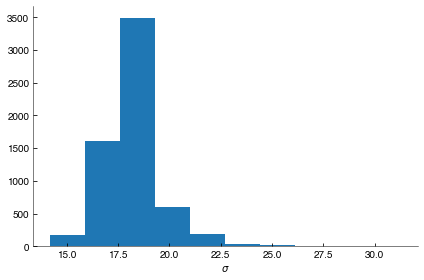

In [8]:
plt.hist(2*centres.radius); plt.xlabel('$\sigma$');

In [9]:
x, y, z = centres.unpack()
color = np.array([(x-x.min())/x.ptp(),np.ones_like(x), np.ones_like(x)]).T
ipv.scatter(x, y, z, size=centres.radius/2.5, marker="sphere", color=color)

x, y, z = contacts.unpack()
ipv.scatter(x, y, z, size=0.9, marker="sphere", color='red')
ipv.show()

## Example of analysis

We show hee how we can proceed to explore the data. For example, we get the nearest contacts for every particle centre. To do so, we fix a cutoff radius `rcut` for our search. 

In [10]:
from scipy.spatial import cKDTree

rcut = centres.radius.mean()*1.1
centre_tree = cKDTree(centres.coord)
contact_tree = cKDTree(contacts.coord)
centre_contacts=centre_tree.query_ball_tree(contact_tree, rcut)

By the same means, we can easily estimate the radial distribution function `g(r)`.

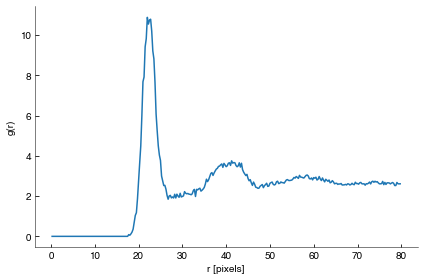

In [11]:
dr =0.25
r = np.arange(dr,80,dr)
nb = centre_tree.count_neighbors(centre_tree,r, cumulative=False)
nb[0]=0 # ignore self-distances
V = np.prod(centres.coord.ptp(axis=0))
N  = centres.coord.shape[0]
g = nb/(4*np.pi*r**2*dr)*V/(N*(N-1))
plt.plot(r,g); plt.xlabel('r [pixels]'); plt.ylabel('g(r)');

Similarly, we can compute the coordination within a larger cutoff, for example around the first minimum of `g(r)`.

In [12]:
rcut = 27
neighs=centre_tree.query_ball_tree(centre_tree,rcut)
coordination = [len(n) for n in neighs]

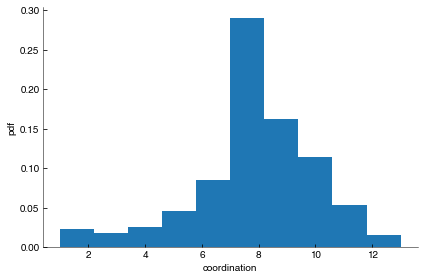

In [13]:
plt.hist(coordination, density=True); plt.xlabel('coordination');plt.ylabel('pdf');

We can also plot a correlation plot between coordination and total contact volume on a particle  (a proxy for the pressure?).

In [14]:
total_contact = [ ]
for c in centre_contacts:
    if len(c)>0:
        total_contact.append(sum(c))
    else:
        total_contact.append(0)

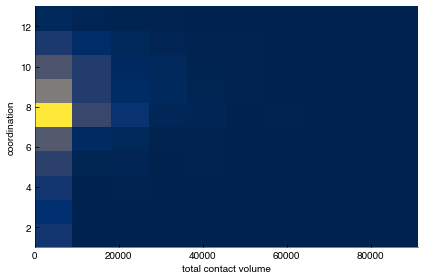

In [18]:
plt.hist2d(total_contact, coordination,bins=10, cmap= plt.cm.cividis);
plt.xlabel('total contact volume'); plt.ylabel('coordination');

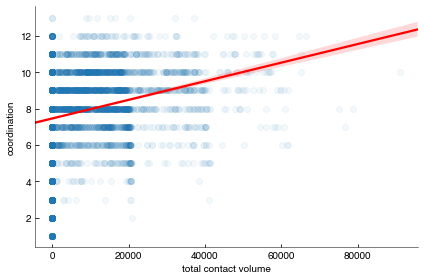

In [17]:
import seaborn as sb
sb.regplot(total_contact, coordination,scatter_kws={'alpha':0.05}, line_kws={'color':'red'});
plt.xlabel('total contact volume'); plt.ylabel('coordination');